In [1]:
from fastprogress import progress_bar
import torch
import matplotlib as mpl
import fastcore.all as fc
from datasets import load_dataset
from miniai.datasets import inplace, DataLoaders

/Users/carles/mambaforge/envs/miniai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from miniai.utils import set_seed
from pathlib import Path
from miniai.diffusion import dl_ddpm
import torch.nn.functional as F
import torchvision.transforms.functional as TF


In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 128
dsd = load_dataset(name)

In [5]:
@inplace
def transformi(b): 
    b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

In [6]:
tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train'], bs=bs), dl_ddpm(tds['test'], bs=bs))

In [7]:
dl = dls.train
(xt,t),eps = b = next(iter(dl))

# Train

In [8]:
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from miniai.learner import DeviceCB, ProgressCB, MetricsCB
from miniai.sgd import BatchSchedCB
from miniai.accel import MixedPrecision
from miniai.unet import EmbUNetModel
from miniai.learner import Learner
import torch.nn as nn

In [9]:
lr = 1e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)

sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]

model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

/Users/carles/mambaforge/envs/miniai/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


/Users/carles/mambaforge/envs/miniai/lib/python3.11/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [11]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [12]:
torch.save(model.state_dict(), mdl_path/'fashion_ddpm_state_dict.ckpt')

In [13]:
torch.cuda.empty_cache()

In [14]:
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)
model.load_state_dict(torch.load(mdl_path/'fashion_ddpm_state_dict.ckpt'))

<All keys matched successfully>

# Sampling

In [15]:
from miniai.diffusion import ddim_step, sample
from miniai.plotting import show_images

In [16]:
sz = (128,1,32,32)
model = model.to('cuda')

In [17]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)
s.min(),s.max(),s.shape

(tensor(-2.), tensor(2.), torch.Size([128, 1, 32, 32]))

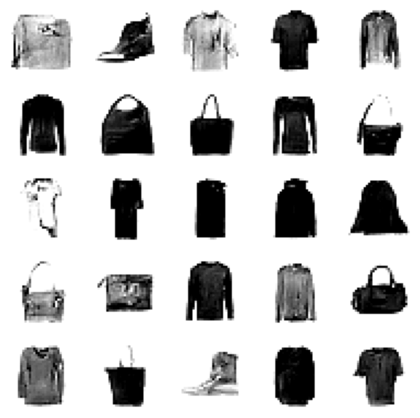

In [18]:
show_images(s[:25].clamp(-1,1), imsize=1.5)